In [1]:
import pandas as pd
from scipy.constants import R, physical_constants
from scipy.stats import linregress
import math
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

# Elektrolyseur

## Gleichgewichtsdruck

\begin{align*}\label{eq:wasser-elektrolyse}
    H_{2}O_{(l)} &-> H_{2, (g)} + \dfrac{1}{2} O_{2, (g)}
\end{align*}

\begin{align*}
    p_{H_{2}} = p_{O_{2}} =& p_{0} \cdot exp\bigg(\big(\Delta E_{0} - \Delta E\big) \cdot \dfrac{z \cdot F}{R \cdot T} \cdot \dfrac{2}{3}\bigg)
\end{align*}


$\Delta E_{0}$ Elektrolyse von $H_{2}O$ = -$\Delta E_{0}$ Knallgasreaktion = -1.299 $V$

p für 2 $\Delta E$ berechnen

\begin{itemize}
    \item \Delta E = -1 V
    \item \Delta E = -1.35 V
\end{itemize}

$T_{labor}$ = 295 K

In [2]:
# Temperatur im Labor
T = 295

# Standarddruck
p0 = 101_300 # Pa

# Bei der Reaktion übertragene Ladung
z = 2

# deltaE0 Wasser Zersetzung / V
dE0 = -1.229 # V

# p bei 2 deltaE berechnen: -1 V & -1.35 V
dE1 = -1.15 # V
dE2 = -1.35 # V

F = physical_constants["Faraday constant"][0]
print("Faraday constant F = {} / {}\nGas constant R = {} / {}".format(F, 
    physical_constants["Faraday constant"][1], R, "J mol^-1 K^-1"))

Faraday constant F = 96485.33212 / C mol^-1
Gas constant R = 8.314462618 / J mol^-1 K^-1


In [3]:
def get_p(p0, dE0, dE):
    return p0 * math.exp((dE0 - dE) * ((z * F) / (R * T)) * (2 / 3))

### Ergebnis

In [4]:
_1 = get_p(p0, dE0, dE1)
_2 = get_p(p0, dE0, dE2)
print("@dE = {} V: p_O2 = p_H2 = {:.3f} Pa".format(dE1, _1))
print("@dE = {} V: p_O2 = p_H2 = {:.3e} Pa".format(dE2, _2))

@dE = -1.15 V: p_O2 = p_H2 = 1607.294 Pa
@dE = -1.35 V: p_O2 = p_H2 = 5.779e+07 Pa


<br>

## Gleichgewichtskonzentration von H2O2
(nur bei dE2 zu berechnen)

\begin{align*}\label{eq:wasser-elektrolyse}
    2 H_{2}O &-> H_{2} + H_{2}O_{2}
\end{align*}

\begin{align*}
    c_{H_{2}O_{2}} =& c_{0} \cdot exp\bigg(\big(\Delta E_{0} - \Delta E\big) \cdot \dfrac{z \cdot F}{R \cdot T} \bigg)
\end{align*}


$\Delta E_{0}$ Bildung von $H_{2}O_{2}$: $\Delta E_{0}$ = -1.77 $V$

p für $\Delta E$ = -1.35 V berechnen

Annahme: $c_{0} = 1 \frac{mol}{L}$

In [5]:
# c0_h2o2
c0 = 1 # mol / L

# EMK von der H2O2 Bildung
dE0_h2o2 = -1.77 # V

In [6]:
def get_c(c0, dE0_h2o2, dE):
    return c0 * math.exp((dE0_h2o2 - dE) * ((z * F) / (R * T)))

### Ergebnis

In [7]:
_c = get_c(c0, dE0_h2o2, dE2)
print(fr"@dE = {dE2} V: c_H2O2 = {_c:.3e} mol L^-1")

@dE = -1.35 V: c_H2O2 = 4.461e-15 mol L^-1


<br>

## I-U Kennlinie

In [260]:
i_vs_u = pd.read_csv("raw_data/Elektrolyseur_i_vs_u.csv", skiprows=1)

In [261]:
i_vs_u.head()

I / mA  U_mess / V  U_netz / V
0     0.4       0.506         0.5
1     0.6       0.604         0.6
2     0.7       0.704         0.7
3     0.8       0.810         0.8
4     0.9       0.905         0.9

In [262]:
#-------------------------------------
# Linear fit
#-------------------------------------

x, y = i_vs_u["U_mess / V"], i_vs_u["I / mA"]

lin_range1 = {"x": x[:-5], "y": y[:-5]}
lin_range2 = {"x": x[-4:], "y": y[-4:]}

lin_reg1 = linregress(lin_range1["x"], lin_range1["y"])
print("fit1: a = {:.3f}, b = {:.3f}\nPearson's r = {:.3f}".format(
    lin_reg1.slope, lin_reg1.intercept, lin_reg1.rvalue), "\n")

lin_reg2 = linregress(lin_range2["x"], lin_range2["y"])
print("fit2: a = {:.3f}, b = {:.3f}\nPearson's r = {:.3f}".format(
    lin_reg2.slope, lin_reg2.intercept, lin_reg2.rvalue))

fit1: a = 0.326, b = 0.465
Pearson's r = 0.495 

fit2: a = 1785.156, b = -2634.150
Pearson's r = 0.986


<br>

Schnittpunkt von 2 Geraden ermitteln<br>
$y_{1} = a_{1} \cdot x_{1} + b_{1}$<br>
$y_{2} = a_{2} \cdot x_{2} + b_{2}$<br>

<br>

$y_{1} = y_{2}\ \ -> \ \ a_{1} \cdot x_{1} + b_{1} = a_{2} \cdot x_{2} + b_{2}$

$=>$
<br>

x = $\dfrac {b_{2} - b_{1}}{a_{1} - a_{2}}\ ,\ \ y = \dfrac {a_{1}b_{2} - a_{1}b_{1}}{a_{1} - a_{2}} + b_{1}$

In [263]:
def get_interception_point(a, b, a2, b2):
    x = (b2 - b) / (a - a2)
    y = ((a * b2 - a * b) / (a - a2)) + b
    return x, y

### Ergebnis

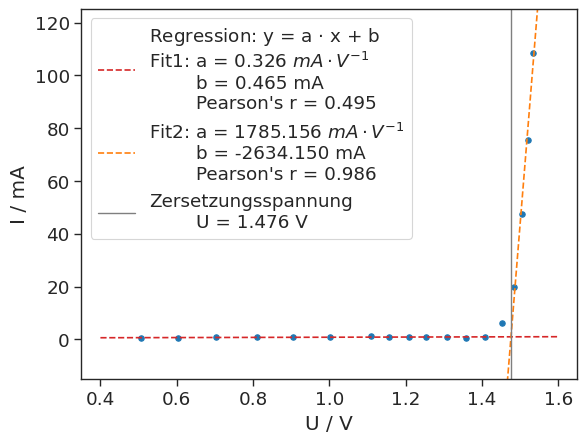

In [265]:
#-------------------------------------
# Plotting
#-------------------------------------

sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5)

fig, ax = plt.subplots()
ax.scatter(x=i_vs_u["U_mess / V"],
           y=i_vs_u["I / mA"],
           s=15,
           c="C0")

ax.plot(np.linspace(0.4,1.6,100), (lin_reg1.slope * np.linspace(0.4,1.6,100) + lin_reg1.intercept),
        c="C3", ls="dashed",
        label=fr"""Regression: y = a $\cdot$ x + b
Fit1: a = {lin_reg1.slope:.3f} $mA \cdot V^{{{-1}}}$
        b = {lin_reg1.intercept:.3f} mA
        Pearson's r = {lin_reg1.rvalue:.3f}""")

ax.plot(np.linspace(1.4,1.6,10), (lin_reg2.slope * np.linspace(1.4,1.6,10) + lin_reg2.intercept),
        c="C1", ls="dashed",
        label=fr"""Fit2: a = {lin_reg2.slope:.3f} $mA \cdot V^{{{-1}}}$
        b = {lin_reg2.intercept:.3f} mA
        Pearson's r = {lin_reg2.rvalue:.3f}""")

_ = get_interception_point(
    lin_reg1.slope, lin_reg1.intercept,
    lin_reg2.slope, lin_reg2.intercept)

zersetzungspunkt = {"x": _[0], "y": _[1]}

ax.axvline(zersetzungspunkt["x"], 0, 1, c="C7", lw=1,
           label="""Zersetzungsspannung
        U = {:.3f} V""".format(zersetzungspunkt["x"]))

ax.set_ylabel("I / mA")
ax.set_xlabel("U / V")

ax.set_ylim([-15,125])
ax.set_xlim([0.35,1.65])

plt.legend()
plt.plot()
# plt.savefig("../protokoll/fig/I-U_elektrolyseur.png", dpi=600, bbox_inches="tight")
None

<br>

## Wirkungsgrade

In [247]:
wg = pd.read_csv("raw_data/Elektrolyseur_h2vol.csv", skiprows=2)

In [248]:
wg["V / mL"] = wg["V / mL"] - 8

In [249]:
wg.head()

V / mL t / m:s  U_mess / V  I / mA  U_netz / V
0       0       0       1.535   106.2        1.65
1       1    1:11       1.535   106.2        1.65
2       2    2:26       1.535   106.2        1.65
3       3    3:45       1.535   106.0        1.65
4       4    4:55       1.536   105.9        1.65

In [221]:
wg.head()

U / V  I / mA  t / s  V / mL
0  1.600     362     39       2
1  1.600     362     60       3
2  1.600     362     83       4
3  1.600     362    104       5
4  1.601     362    127       6

### Leckrate

Diffusionsrate und Korrigiertes Volumen

\begin{align*}
    D &= \dfrac{\Delta V_{Leck}}{t}
    \\ \\
    V_{eff} &= V_{mess} + D \cdot t
\end{align*}

In [250]:
#-------------------------------------
# Diffusionskoeffizientenbestimmung
#-------------------------------------

# Startvolumen
V_s = 30.1 # mL

# Endvolumen
V_e = 29.95 # mL

# Länge der Leckratenmessung
t = "1:30.11" # s

def to_seconds(t):
    try:
        ms = t.split(":")
        return float(ms[0]) * 60 + float(ms[1]) if len(ms) == 2 else float(ms[0])
    except:
        return t

D = (V_s - V_e) / to_seconds(t)

wg["t / m:s"] = wg["t / m:s"].apply(to_seconds)
wg.rename(columns={"t / m:s": "t / s"}, inplace=True)

print(f"Diffusionskoeffizient: {D:.2e} mL/s")

Diffusionskoeffizient: 1.66e-03 mL/s


In [251]:
#-------------------------------------
# V-Korrektur & Umrechnen mL -> m3
#-------------------------------------

wg["V / mL"] = wg.apply(lambda wg: wg["V / mL"] + D * wg["t / s"], axis=1)
wg["V / mL"] = wg["V / mL"].apply(lambda V: V * 1e-6)
wg.rename(columns={"V / mL": "V / m3"}, inplace=True)

Korrigierter Druck
\begin{align*}
    p_{eff} = p_{mess} - p_{H_{2}O}
\end{align*}

In [252]:
#-------------------------------------
# p Korrektur
#-------------------------------------

# Umgebungsdruck am Versuchstag
p_mess = 100_700 # Pa


# H2O Dampfdruck bei Messtemperatur (295 K)
p_h2o = 2_640 # Pa

wg["p / Pa"] = p_mess - p_h2o

print(f"Korrigierter Druck: {p_eff:.2e} Pa")

Korrigierter Druck: 9.81e+04 Pa


Berechnung der Stoffmenge
\begin{align*}
    n &= \dfrac{p \cdot V}{R \cdot T}
\end{align*}

In [253]:
#-------------------------------------
# Stoffmenge berechnen
#-------------------------------------

wg["n / mol"] = wg.apply(lambda wg: (wg["V / m3"] * wg["p / Pa"])/(R * T), axis=1)

In [254]:
#-------------------------------------
# I in mA -> A
#-------------------------------------

wg["I / mA"] = wg["I / mA"].apply(lambda I: I * 1e-3)
wg.rename(columns={"I / mA": "I / A"}, inplace=True)

In [255]:
#-------------------------------------
# Wirkungsgrade
#-------------------------------------

# Konstanten (aus Praktikumsanleitung Unterlagen Teil 1)
dG0_298 = -237_130 # J / mol
dH0_298 = -285_830 # kJ / mol

# Elektrischer Wirkungsgrad
def get_eta_el(n,U,I,t): 
    if U == 0 or I == 0 or t == 0:
        return 0
    else:
        return (-(dG0_298 * n) / (U * I * t))

# Praktischer Wirkungsgrad
def get_eta_pr(n,U,I,t):
    if U == 0 or I == 0 or t == 0:
        return 0
    else:
        return (-(dH0_298 * n) / (U * I * t))

# Faraday'scher Wirkungsgrad
def get_eta_fa(n,I,t):
    if I == 0 or t == 0:
        return 0
    else:
        return ((z * n * F) / (I * t))


wg["eta_el"] = wg.apply(lambda wg: get_eta_el(wg["n / mol"],wg["U_mess / V"],wg["I / A"],wg["t / s"]), axis=1)

wg["eta_pr"] = wg.apply(lambda wg: get_eta_pr(wg["n / mol"],wg["U_mess / V"],wg["I / A"],wg["t / s"]), axis=1)

wg["eta_fa"] = wg.apply(lambda wg: get_eta_fa(wg["n / mol"],wg["I / A"],wg["t / s"]), axis=1)

In [256]:
wg.head()

V / m3  t / s  U_mess / V   I / A  U_netz / V  p / Pa   n / mol   
0  0.000000    0.0       1.535  0.1062        1.65   98060  0.000000  \
1  0.000001   71.0       1.535  0.1062        1.65   98060  0.000045   
2  0.000002  146.0       1.535  0.1062        1.65   98060  0.000090   
3  0.000003  225.0       1.535  0.1060        1.65   98060  0.000135   
4  0.000004  295.0       1.536  0.1059        1.65   98060  0.000180   

     eta_el    eta_pr    eta_fa  
0  0.000000  0.000000  0.000000  
1  0.915896  1.103996  1.144088  
2  0.893455  1.076946  1.116056  
3  0.873857  1.053323  1.091575  
4  0.887284  1.069507  1.109069

### Ergebnis

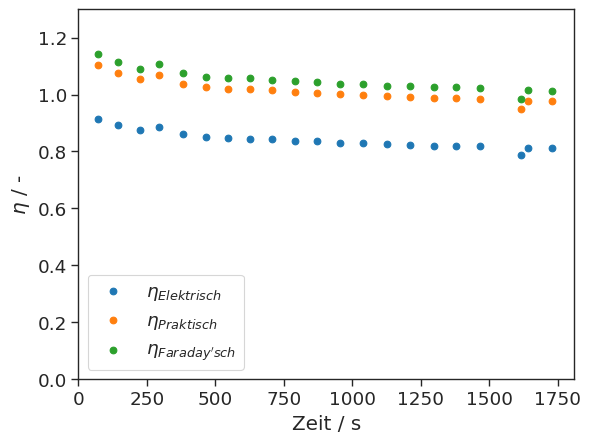

In [259]:
#-------------------------------------
# Plotting
#-------------------------------------

sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5)

fig, ax = plt.subplots()

ax.scatter("t / s", "eta_el", data=wg[1:], c="C0", label=r"$\eta_{Elektrisch}$")
ax.scatter("t / s", "eta_pr", data=wg[1:], c="C1", label=r"$\eta_{Praktisch}$")
ax.scatter("t / s", "eta_fa", data=wg[1:], c="C2", label=r"$\eta_{Faraday'sch}$")

ax.set_ylabel(r"$\eta$ / -")
ax.set_xlabel("Zeit / s")

ax.set_xlim((0,None))
ax.set_ylim((0,1.3))

ax.legend()
None

<br>

---------------------------------

---------------------------------

<br>

# Brennstoffzelle

## I-U Kennlinie

In [29]:
df1 = pd.read_csv("raw_data/BRZ_i_vs_u.csv")

In [30]:
# Spannung in V, Strom in mA, T in K 
df1.assign(U_netz=1.96, I_netz=2.03, T_labor=295).astype('category', copy=False)

Amperemeter Messbereich  R / Ohm  U_mess / V  I / mA U_netz I_netz T_labor
0                  200 mA      inf       0.943     0.0   1.96   2.03     295
1                  200 mA   330.00       0.883     2.6   1.96   2.03     295
2                  200 mA   100.00       0.836     8.2   1.96   2.03     295
3                  200 mA    33.00       0.786    23.3   1.96   2.03     295
4                  200 mA    10.00       0.725    64.6   1.96   2.03     295
5                  200 mA     3.30       0.648   154.3   1.96   2.03     295
6                     2 A     1.00       0.492   392.0   1.96   2.03     295
7                     2 A     0.33       0.376   616.0   1.96   2.03     295
8                     2 A     0.10       0.297   789.0   1.96   2.03     295
9                     2 A     0.00       0.254   886.0   1.96   2.03     295

<br>

## Wirkungsgrad

In [31]:
df2 = pd.read_csv("raw_data/BRZ_h2vol.csv").assign(Widerstand=0.33) # R in Ohm

In [32]:
def min_to_sec(x):
    x = str(x)
    x = x.split(":")
    if len(x) == 2:
        return float(x[0]) * 60 + float(x[1])
    return float(x[0])

In [33]:
df2["t / s"] = df2["t / m:s"].apply(min_to_sec)
df2.drop(["t / m:s"], axis=1, inplace=True)

In [34]:
df2

V / mL  U / V  I / mA  Widerstand   t / s
0      23  0.403     651        0.33   17.12
1      22  0.394     640        0.33   26.26
2      21  0.390     632        0.33   35.17
3      20  0.385     626        0.33   43.94
4      19  0.381     619        0.33   52.89
5      18  0.373     605        0.33   62.38
6      17  0.322     510        0.33   78.68
7      16  0.162     253        0.33  108.61
8      15  0.083     130        0.33  123.32

### Leckrate

In [35]:
# Startvolumen
V_s = 16.9 # mL

# Endvolumen
V_e = 16.25 # mL

# Länge der Leckratenmessung
t_m = 60.19 # s

<br>